# LSI31003 Machine Learning in Molecular Biology Assignment 3

In [77]:
# Loading modules
library(ggplot2)
library(rBeta2009)
library(grid)
library(repr)
library(reshape2)
library(Rmisc)
library(ggpmisc)
library(gplots)
library(pastecs)
library(ggfortify)
library(Rtsne)
library(hexbin)

##  Introduction <a id='section1'></a>

In this assignment, we will explore data visualisation and density based clustering with t-SNE and K-Means . We use the same data set of somatic mutations as in assignments 1 and 2 from ["Alexandrov LB, et al. (2013) Signatures of mutational processes in human cancer. Nature 500(7463):415–421"](https://www.nature.com/articles/nature12477).

In [4]:
## Import data:
data_path<-"/Users/qingli/Desktop/Course/MLinMolecularBiology/Exercise/data/"
channels96<-paste(data_path,"MutSigCancer/channels96.csv",sep="")
channels96<-read.csv(channels96)

somatic<-paste(data_path,"MutSigCancer/somaticMutations.csv",sep="")
somaticMutations<-read.csv(somatic)

cosmic<-paste(data_path,"MutSigCancer/cosmic30.csv",sep="")
cosmic30<-read.csv(cosmic)

## change the colunm names of somaticMutations(because those like "@|>" are converted into "." by python):
colnames(somaticMutations)<-c("cancer_type",as.character(channels96$mutation))

## head of the data files:
head(channels96,2)
tail(somaticMutations,2)
head(cosmic30,2)

mutation.type,mutation.context,mutation
C>A,A_A,C>A@A_A
C>A,A_C,C>A@A_C


,cancer_type,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,⋯,T>G@C_G,T>G@C_T,T>G@G_A,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T
7015,Uterus,1,1,1,0,2,0,0,0,1,⋯,0,1,0,0,0,0,0,0,0,0
7016,Uterus,1,0,3,0,1,1,0,1,0,⋯,1,0,0,0,1,1,0,0,0,0


X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0.0110983262,0.0091493407,1.490070e-03,0.0062338852,0.006595870,0.007342368,8.928404e-04,0.0071865816,0.0082326040,0.0057580214,⋯,0.0015995485,2.758538e-03,9.904500e-05,2.023656e-04,0.0011883532,8.007233e-04,1.397554e-03,1.291737e-03,0.0020310769,0.0040301282
0.0006827082,0.0006191072,9.927896e-05,0.0003238914,0.000677445,0.000213681,6.770460e-06,0.0004163329,0.0003520134,0.0001338169,⋯,0.0002282459,6.711134e-05,9.555239e-05,4.700238e-05,0.0001099257,8.647718e-05,7.173695e-05,1.428146e-05,0.0002066152,0.0000235982


### Problem 1: Visualisation of cancer genotypes with PCA and t-SNE <a id='Problem1'></a>

#### Problem 1a: 
First, normalize the 96-dimensional vectors of somatic mutations such that each sample is a probability distribution over the 96 channels. Run then a two-component principal component analysis on those vectors and plot the samples on a plane of first and second principal component. Can you see any clusters? Print out the explained variance ratio. Hint: decomposition.PCA

In [5]:
## make a copy of somaticMutations. and put the normalized values to somaticMutations_prop;
somaticMutations_prop<-somaticMutations
row_n<-dim(somaticMutations_prop)[1]
## calculte the normalized proportion in 96 channels for each cancer type replace the values in each channel:

#for(i in 1:row_n){
#    somaticMutations_prop[i,2:97]<- somaticMutations_prop[i,2:97]/somaticMutations_prop$total[i]
#}
total<-apply(somaticMutations_prop[,2:97],1,sum)
somaticMutations_prop[,2:97]<-apply(somaticMutations_prop[,2:97],2, function(x) x/total)
#summary
"The normalized 96-channel frequency in all cancer samples:"
head(somaticMutations_prop,2)
"To check if the total frequency will be sum up to 1 as expected:"
sum(somaticMutations_prop[23,2:97])

somaticMutations$total<-as.numeric(apply(somaticMutations[,2:97],1,function(x) sum(x)))
    

[1] "The normalized 96-channel frequency in all cancer samples:"

cancer_type,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,⋯,T>G@C_G,T>G@C_T,T>G@G_A,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] "To check if the total frequency will be sum up to 1 as expected:"

[1] 1

#### 96-dimensional somatic mutations

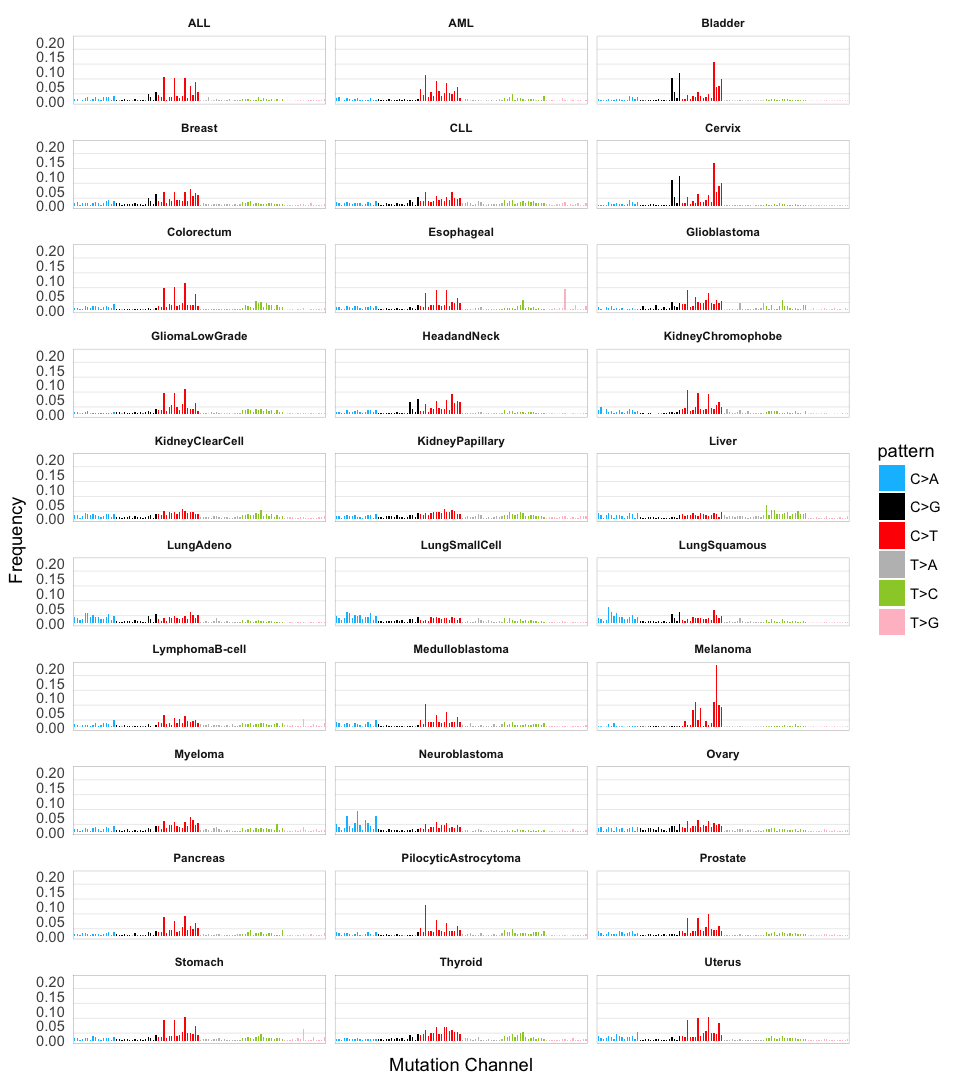

In [6]:
cancers<-somaticMutations$cancer_type
cancer_uniq<-unique(cancers)
cancer_types_num<-length(cancer_uniq)

## Format the data for plot
mean_count<-NULL
prop_name<-NULL
prop_96_order<-NULL
prop_pattern<-NULL
prop_context<-NULL

## reminder: cancer_types_num<-length(cancer_uniq)
for (i in 1:cancer_types_num){## for each cancer type
    prop_name<-c(prop_name,replicate(96,as.character(cancer_uniq[i])))
    prop_96_order<-c(prop_96_order,1:96)
    prop_context<-c(prop_context,as.character(channels96$mutation.context))
    prop_pattern<-c(prop_pattern,as.character(channels96$mutation.type))
    
    cancer_logical_index<-somaticMutations$cancer_type == cancer_uniq[i]
    aa<-somaticMutations_prop[cancer_logical_index,2:97]    
    for (j in 1:96){
        mean_count<-c(mean_count,as.numeric(mean(aa[,j])))
    }
}
#class(mean_count)
normalized_cancer_data<-data.frame(cancer_type=prop_name,pattern=prop_pattern,context=prop_context,order=as.factor(prop_96_order),count=mean_count)
normalized_cancer_data$cancer_order<-factor(normalized_cancer_data$cancer_type,levels=as.vector(cancer_uniq))
color_scheme<-c("deepskyblue","black","red","grey","yellowgreen","pink")

## for ploting:
options(repr.plot.width=8, repr.plot.height=9)
plot2<-ggplot(data=normalized_cancer_data,aes(x=order,y=count,fill=pattern))+geom_bar(stat="identity",width=0.5,size=.5)
plot2<-plot2+theme_minimal()+theme( axis.text.x=element_blank(),
                                    axis.ticks.x=element_blank(),
                                    panel.grid.major=element_blank(),                                   
                                    panel.border = element_rect(colour = "black", fill=NA, size=0.1),
                                    strip.text.x = element_text(face ="bold",size = 7,vjust = 0,hjust = 0.5))

plot2<-plot2+scale_fill_manual(values=color_scheme)+xlab("Mutation Channel") +ylab("Frequency")
plot2+facet_wrap(~ cancer_order,ncol=3)

#### PCA plot

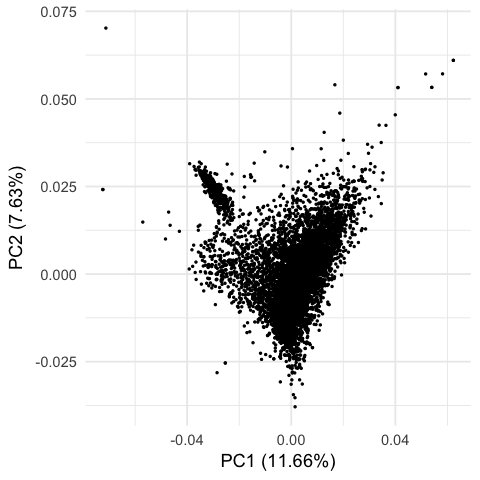

In [44]:
somaticMutations_pca<-prcomp(somaticMutations_prop[,2:97])
options(repr.plot.width=4, repr.plot.height=4)
autoplot(somaticMutations_pca, data =somaticMutations_prop,size=0.3)+theme_minimal()

#### Summary of the proportion of variance from above PCA analysis

#### The top two components could only explain about 20% of the variance of the data

In [8]:
summary(somaticMutations_pca)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.07896 0.06387 0.05790 0.04718 0.04580 0.03962 0.03694
Proportion of Variance 0.11658 0.07626 0.06267 0.04162 0.03921 0.02934 0.02552
Cumulative Proportion  0.11658 0.19284 0.25552 0.29714 0.33635 0.36569 0.39121
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.03619 0.03332 0.03297 0.03162 0.03137 0.02992 0.02919
Proportion of Variance 0.02448 0.02076 0.02032 0.01869 0.01840 0.01674 0.01593
Cumulative Proportion  0.41569 0.43645 0.45677 0.47547 0.49386 0.51060 0.52653
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.02854 0.02829 0.02801 0.02700 0.02619 0.02577 0.02553
Proportion of Variance 0.01523 0.01496 0.01467 0.01363 0.01282 0.01242 0.01218
Cumulative Proportion  0.54176 0.55672 0.57138 0.58501 0.59783 0.61025 0.62243
                          

#### Problem 1b:
Add colouring of samples by cancer type to the previous figure. That is, assign each cancer type a separate colour and plot the samples again on the plane of first two principal components. Do various cancer types show up uniformly in the map? Hint matplotlib colormaps

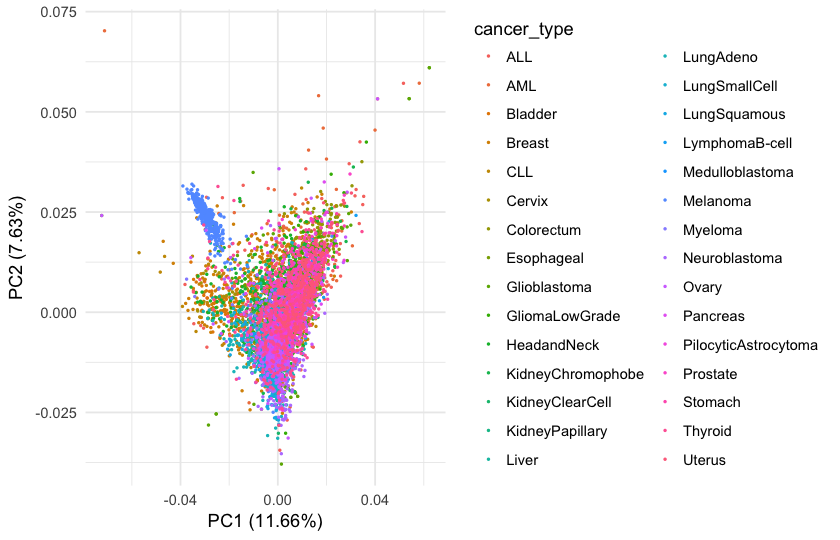

In [46]:
options(repr.plot.width=7, repr.plot.height=4.5)
autoplot(somaticMutations_pca, data =somaticMutations_prop, colour ='cancer_type',size=0.3)+theme_minimal()

#### There is one cluster shown in the above figure (bule color) which seems like lung cancer. But most of them have been mixed together based on principle components analysis.

#### Problem 1c: 
Run 2-component t-SNE with cosine metric on the 96-dimensional samples and plot the components again in 2 dimensions with the colouring by cancer type. You can use PCA as the initial state in the algorithm. Test a few values of perplexity, learning rate, and number of iterations until you find clear structure in the map, e.g. perplexity=30, n_iter=2500, learning_rate=500 is a starting point. Plot your best result. 

Hint: sklearn.manifold.TSNE . Note: The computation may take some time, even 10 minutes. 

#### I have tried different parameters for the plot and a better one is shown here. What we could see by eye are a few clusters, like bule cluster in the left, water blue in the left bottom, grass green cluster in the right bottom, red cluster on the right side and few ones hidden in the center. It implies that the same type of cancer samples are also found in thte same cluster.

In [40]:
set.seed(5)
tsne <- Rtsne(as.matrix(somaticMutations_prop[,2:97]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=35,max_iter=3000,alpha=0.5)

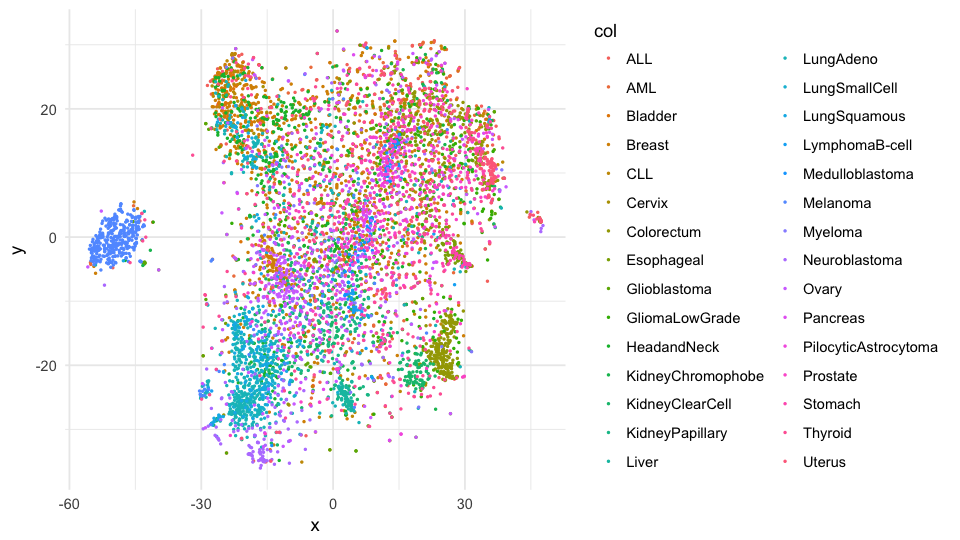

In [48]:
options(repr.plot.width=8, repr.plot.height=4.5)
tsne_plot <- data.frame(x = tsne$Y[,1], y = tsne$Y[,2], col = somaticMutations_prop$cancer_type)
ggplot(tsne_plot) + geom_point(aes(x=x, y=y, color=col),size=0.3)+theme_minimal()

### Problem 2: Density based clustering <a id='Problem2'></a>

#### Problem 2 a: 
Plot the components of t-SNE again but with a colour coding given by the density heat map of the points (e.g. red for high and blue for low density). Plot in another figure just the points that belong to high-density areas. You can pick the threshold for 'high density' yourself such that you get clear clusters. 

Hint: 

xy = np.vstack([tsne_results[:, 0], tsne_results[:, 1]])

z = gaussian_kde(xy, 0.05)(xy)

z=z/np.max(z) 

#### The figure below is the density scatter plot of the same data. We can easily check out by eye that there are roughly 7 clusters in our data.

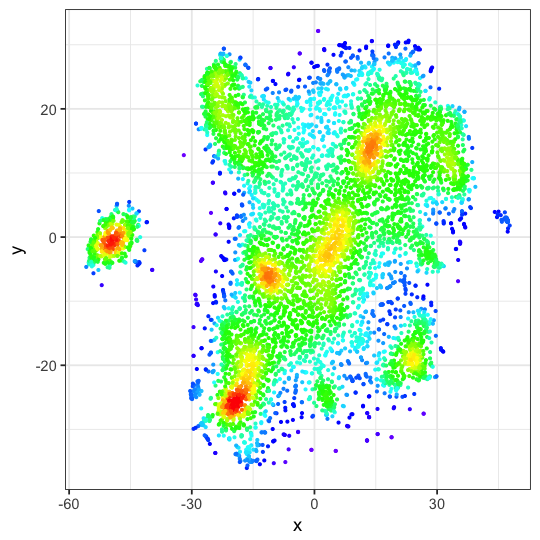

In [104]:
df <- data.frame(x = tsne$Y[,1], y = tsne$Y[,2],
  d = densCols(tsne$Y[,1], tsne$Y[,2], colramp = colorRampPalette(rev(rainbow(10, end = 4.5/6)))))
p <- ggplot(df) +
    geom_point(aes(x, y, col = d), size = 0.5) +
    scale_color_identity() +
    theme_bw()
plot(p)

#### Next, I have set cut off to just plot the high density points. The color of all points in the above figure has been assigned to a RGB number which could be divided into values of three colors (red, green and blue). We use red color value over 115 and bule color which is 0 as our threeshold. Finally, we have found 8 clusters in our datasets.

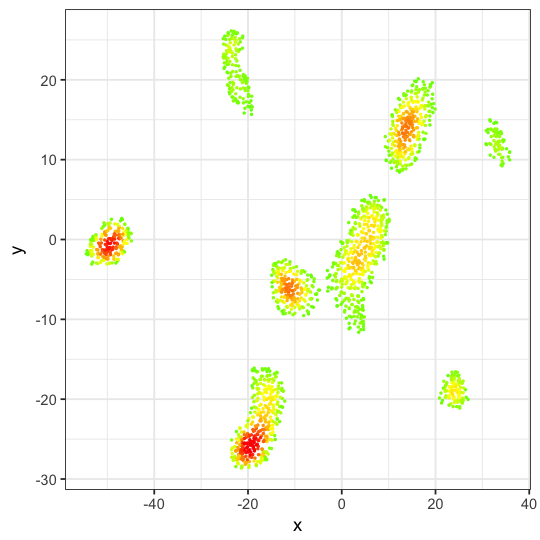

In [149]:
rgb<-col2rgb(df$d)
selected_index<-rgb[1,]>115 & rgb[3,]==0
df_selected<-df[selected_index,]
p <- ggplot(df_selected) +
    geom_point(aes(x, y, col = d), size = 0.3) +
    scale_color_identity() +
    theme_bw()
plot(p)

#### Problem 2 b: 
Run K-means on the high density data and plot the mean profile over the 96 channels in each of these clusters. Do you see any of the signatures listed in http://cancer.sanger.ac.uk/cosmic/signatures ?

#### Pick the samples which are from high density points. We found 1836 samples among 7016 patients.

In [151]:
somaticMutations_prop_selected<-somaticMutations_prop[,2:97][selected_index,]
head(somaticMutations_prop_selected)
dim(somaticMutations_prop_selected)

,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,C>A@G_C,⋯,T>G@C_G,T>G@C_T,T>G@G_A,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T
45,0,0.000,0,0,0.00000000,0,0,0,0,0,⋯,0,0.000,0,0.0000000,0,0,0.000,0,0,0
47,0,0.000,0,0,0.00000000,0,0,0,0,0,⋯,0,0.000,0,0.0000000,0,0,0.000,0,0,0
59,0,0.000,0,0,0.00000000,0,0,0,0,0,⋯,0,0.000,0,0.1666667,0,0,0.000,0,0,0
75,0,0.000,0,0,0.03030303,0,0,0,0,0,⋯,0,0.000,0,0.0000000,0,0,0.000,0,0,0
89,0,0.000,0,0,0.00000000,0,0,0,0,0,⋯,0,0.000,0,0.0000000,0,0,0.000,0,0,0
102,0,0.125,0,0,0.00000000,0,0,0,0,0,⋯,0,0.125,0,0.0000000,0,0,0.125,0,0,0


[1] 1836   96

#### Run K-means on the high density samples.

In [169]:
k<-kmeans(somaticMutations_prop_selected,centers=8,nstart=2,iter.max =100)
k$centers

,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,C>A@G_C,⋯,T>G@C_G,T>G@C_T,T>G@G_A,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T
1,0.025951718,0.020010173,0.0114916861,0.016067458,0.046185691,0.042684997,0.022615817,0.032837878,0.024664758,0.027702768,⋯,0.005056414,0.004034365,0.0010038648,0.0012237034,0.0032081496,0.0017923820,0.0011860527,0.0026562732,0.002903822,0.002551355
2,0.003108165,0.003002446,0.0010277640,0.002795610,0.009071848,0.015151203,0.006203385,0.036637864,0.003757932,0.005650491,⋯,0.005086853,0.006685275,0.0002664047,0.0013154264,0.0019054561,0.0028341270,0.0002194619,0.0017387934,0.001919544,0.001829378
3,0.016515677,0.014112091,0.0027243908,0.008074877,0.010448963,0.008758688,0.003653491,0.009953716,0.013203562,0.009869124,⋯,0.003176666,0.007788490,0.0015360709,0.0027628533,0.0040559596,0.0024573757,0.0037313810,0.0037918955,0.002749200,0.007093775
4,0.016417876,0.019066797,0.0030356731,0.013817427,0.016510429,0.014987046,0.004421824,0.014844393,0.011842252,0.012412176,⋯,0.008451813,0.007701815,0.0026563774,0.0026260853,0.0083512843,0.0049080815,0.0037084519,0.0051928461,0.008695357,0.007707116
5,0.012571546,0.012299936,0.0027666985,0.010414573,0.011397135,0.008113619,0.003973663,0.012453524,0.013264189,0.008307648,⋯,0.005254204,0.007251539,0.0019716019,0.0023993260,0.0037892240,0.0040592379,0.0041144595,0.0039599050,0.004667715,0.008121213
6,0.005266574,0.005283501,0.0015788541,0.003828200,0.018254532,0.013467252,0.014549881,0.013640329,0.010620183,0.007215821,⋯,0.002671557,0.004719505,0.0006135913,0.0013965093,0.0009208161,0.0009467012,0.0010153697,0.0009503163,0.002388563,0.004099030
7,0.003968638,0.005558564,0.0018003987,0.002851064,0.007848468,0.005939032,0.004152645,0.005207075,0.004941910,0.004076854,⋯,0.001868084,0.001901402,0.0004956610,0.0005506469,0.0016195654,0.0007742233,0.0006122449,0.0011599723,0.001281617,0.001951415
8,0.001687882,0.001371186,0.0004106888,0.000929633,0.005813120,0.002403133,0.003777828,0.003338839,0.001222960,0.001053983,⋯,0.001746081,0.002314908,0.0004576519,0.0005279124,0.0033097579,0.0012328046,0.0008183463,0.0014517624,0.001545495,0.002064886


#### Plot the 8 cluster centers over 96 channels.

In [157]:
wholeview_96channles<-function(data,title,width=8,height=40){
    name<-NULL
    pattern<-NULL
    order<-NULL
    context<-NULL
    count<-NULL
    
    for (i in 1:dim(data)[1]){
#        name<-c(name,as.character(replicate(96,mutation_count$sample[i])))
        name<-c(name,as.character(replicate(96,rownames(data)[i])))
        pattern<-c(pattern,as.character(channels96$mutation.type))
        context<-c(context,as.character(channels96$mutation.context))
        order<-c(order,1:96)
        count<-c(count,as.vector(as.matrix(data[i,])))
    }
    sample_96channel_plot<-data.frame(name=name,pattern=pattern,context=context,order=as.factor(order),count=count)
    #head(sample_96channel_plot)
    color_scheme<-c("deepskyblue","black","red","grey","yellowgreen","pink")
    options(repr.plot.width=width, repr.plot.height=height)
    plot2<-ggplot(data=sample_96channel_plot,aes(x=order,y=count,fill=pattern))+geom_bar(stat="identity",width=0.5,size=.5)
    plot2<-plot2+theme_minimal()+theme( axis.text.x=element_blank(),
                                    axis.ticks.x=element_blank(),
                                    panel.grid.major=element_blank(),                                   
                                    panel.border = element_rect(colour = "black", fill=NA, size=0.1),
                                    strip.text.x = element_text(face ="bold",size = 7,vjust = 0,hjust = 0.5))

    plot2<-plot2+scale_fill_manual(values=color_scheme)+xlab("Mutation Channels") +ylab("Mutation Frequency")
    plot2+facet_wrap(~ name,ncol=4,scale="free")+ggtitle(title)
}

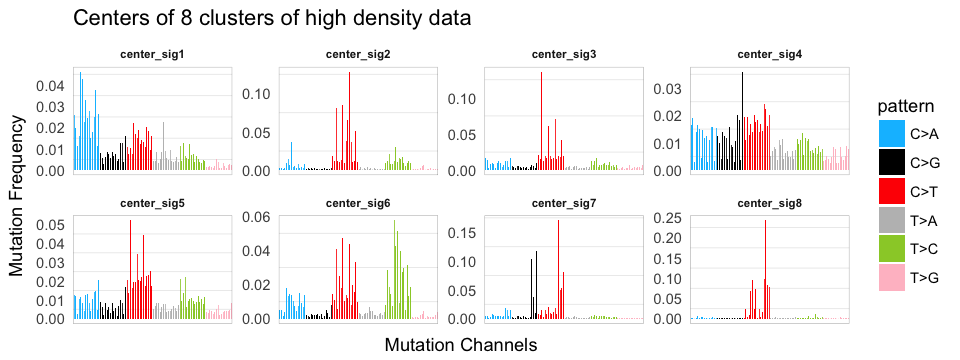

In [174]:
row.names(k$centers)<-paste("center_sig",1:8,sep="")
wholeview_96channles(k$centers,"Centers of 8 clusters of high density data",8,3)

#### Look for the similar signatures compared to COSMIC 30 signatures using consine similarity

In [178]:
## Calculate cosine similarity distance
cosine_similarity<-function(vectorA,vectorB){
    sum_AxB<-0
    sum_A2<-0
    sum_B2<-0
    
    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_AxB<-sum_AxB+vectorA[i,1]*vectorB[i,1]
            sum_A2<-sum_A2+vectorA[i,1]*vectorA[i,1]
            sum_B2<-sum_B2+vectorB[i,1]*vectorB[i,1]
        }
    }
    sum_AxB/(sqrt(sum_A2)*sqrt(sum_B2))
}

In [215]:
## Plot the cluster result based on distance matrix 
simlarity_sig<-function(dataset,width,height,margin1,margin2){
    data<-as.matrix(dataset)
    number_sig<-dim(data)[2]
    dis_matrix<-matrix(replicate(number_sig*number_sig,0),ncol=number_sig)
    ## calculate the cosine matrix
    for (i in 1:number_sig){
        pred_sig<-as.matrix(data[,i])
        for (j in 1:number_sig){
            picked_sig<-as.matrix(data[,j])

            dis_matrix[i,j]<-cosine_similarity(pred_sig,picked_sig)             
            if (dis_matrix[i,j]>0.9 & grepl("center",colnames(data)[i]) & !grepl("center",colnames(data)[j])){
                print (colnames(data)[c(i,j)],dis_matrix[i,j])
            }            
        }
    }
    colnames(dis_matrix)<-colnames(dataset)
    rownames(dis_matrix)<-colnames(dataset)

    dis_matrix_copy<-as.matrix(dis_matrix)
#    print(dis_matrix_copy)
    dis_matrix<- as.dist(as.matrix(dis_matrix))
#    print(dis_matrix)
    options(repr.plot.width=width, repr.plot.height=height)
    mycol <- colorpanel(40, "royalblue4","mistyrose","red4")
   
        heatmap.2(dis_matrix_copy, col=mycol,scale="none", density.info="none",key.xlab="Cosine Similarity", 
              trace="none",margins = c(margin1,margin2),key.title="",keysize = 1.2)
        
}

In [216]:
row.names(cosmic30)<-paste("sig",1:30,sep="_")
colnames(cosmic30)<-colnames(k$centers)

#### Using cosine similarity (over 0.9), we found the center 96-channel distribution, center_sig1/2/3/4/8 which are similar to sig 4/6/1/3/7, respectively. From our above analysis, center_sig4 from the blue cluster (lung cancer) is close to sig 4 reported to be caused by tobacco, which proved our result matched with the previous findings.

[1] "center_sig1" "sig_4"      
[1] "center_sig2" "sig_6"      
[1] "center_sig3" "sig_1"      
[1] "center_sig4" "sig_3"      
[1] "center_sig8" "sig_7"      


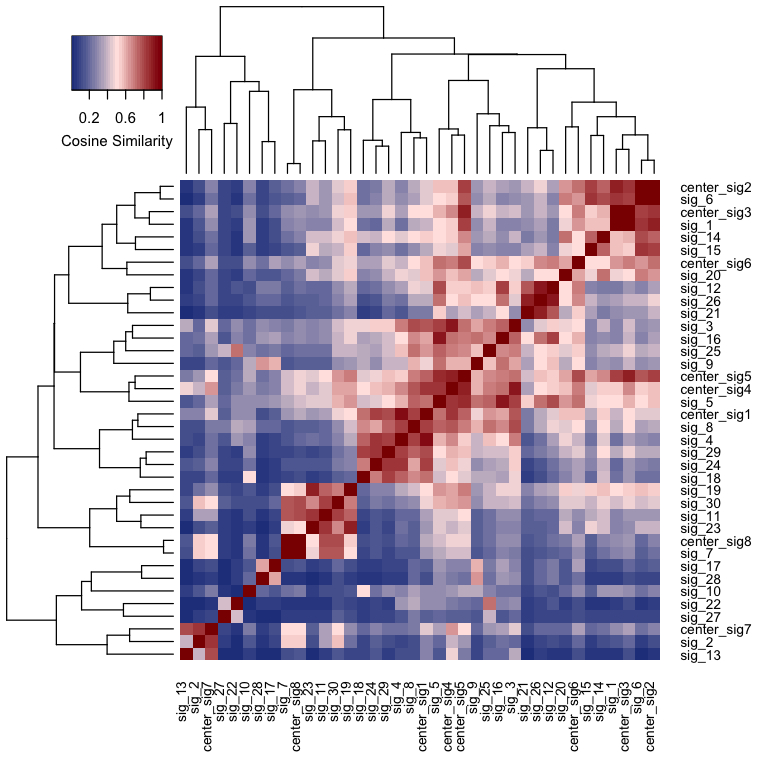

In [219]:
simlarity_sig(t(rbind(k$centers,cosmic30)),6.5,6.5,6,6)